In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [43]:
kc_house_df = pd.read_csv("data/kc_house_data.csv")
kc_house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

yr_renovated seems problematic, could be changed to a categorical column of a renovated yes or no. Also possible to look at columns of differences between yr_renovated and date or yr_built. 

In [5]:
date_range = pd.to_datetime(kc_house_df['date'])
print(date_range.max(), date_range.min())
date_range.loc[(date_range.dt.year != 2014) & (date_range.dt.year != 2015)]

2015-05-27 00:00:00 2014-05-02 00:00:00


Series([], Name: date, dtype: datetime64[ns])

We're dealing with a year of sale data, could do some month to month comparisons, or add in columns with categorized data. On intial inspection it appears there are no null or dummy values.

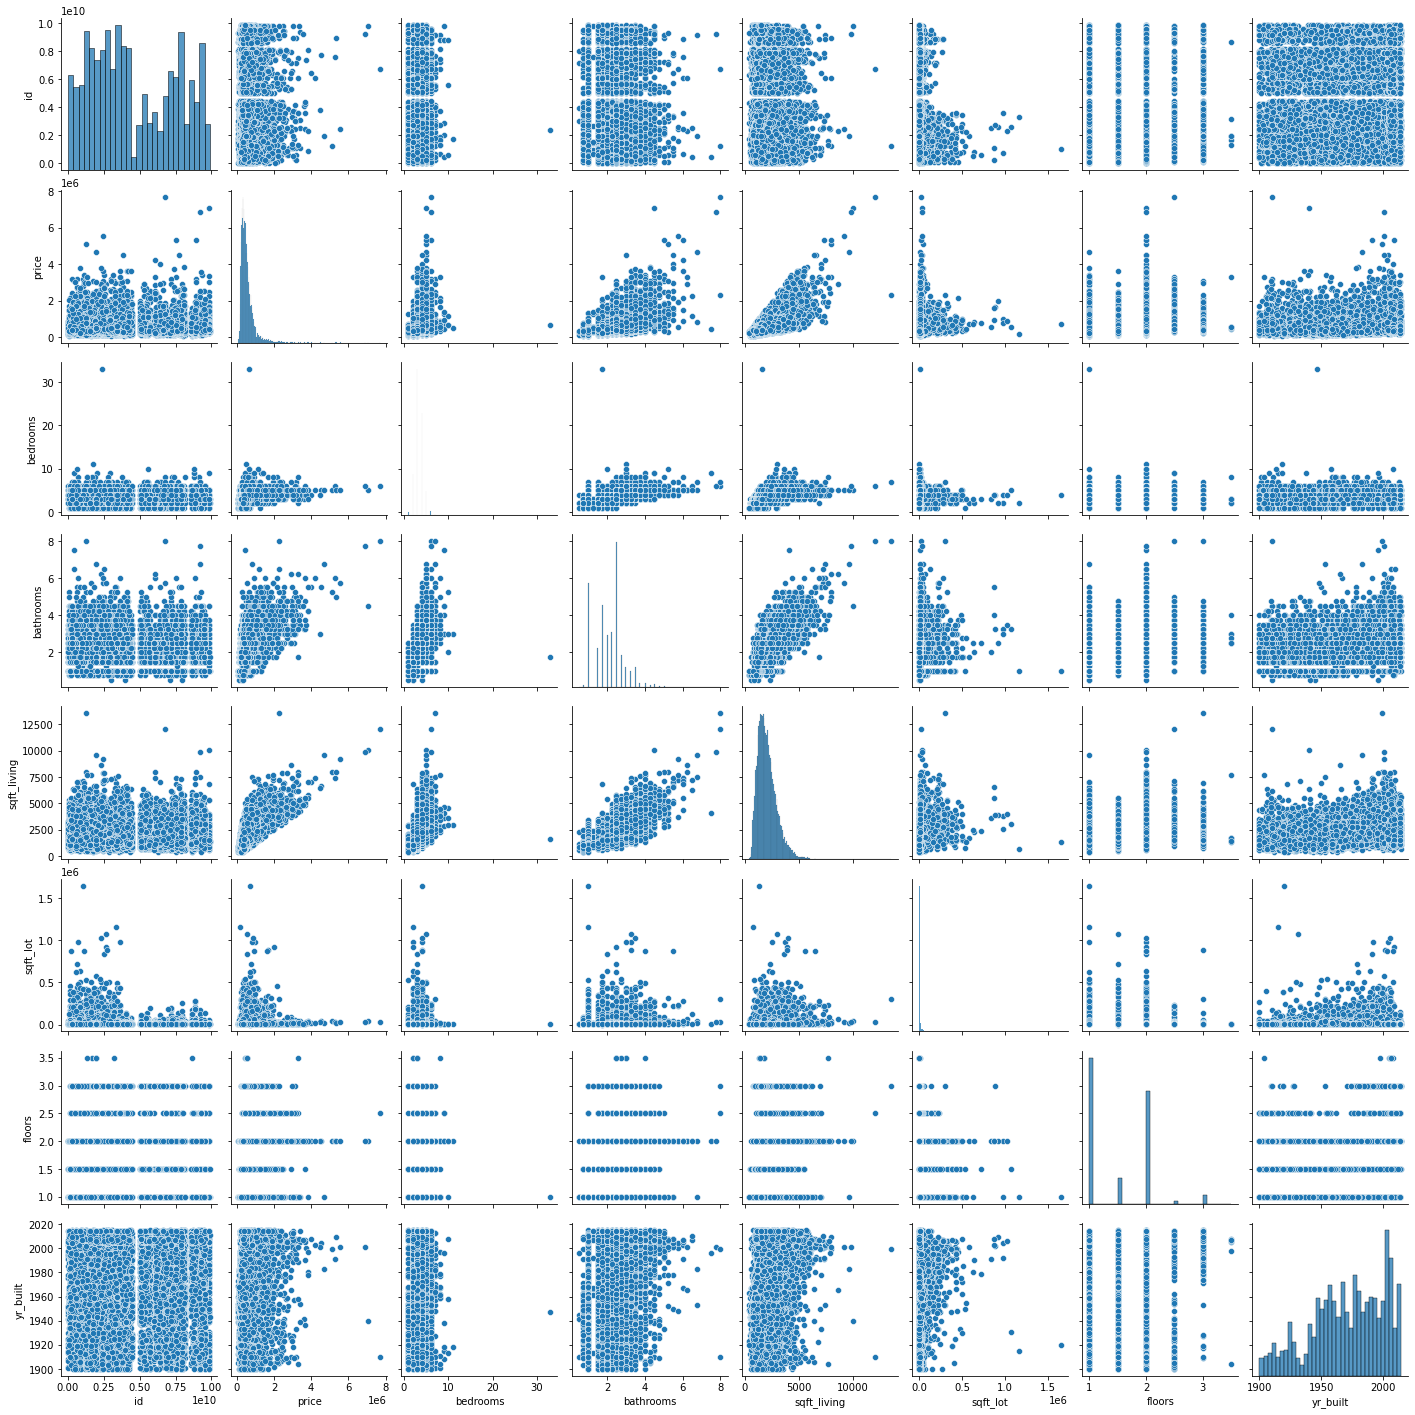

In [6]:
stripped_down_df = kc_house_df.loc[:, ['id', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
sns.pairplot(stripped_down_df) # Pairplot of the recommended columns from the project description. 

<AxesSubplot:>

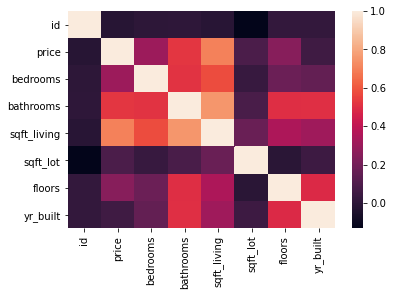

In [7]:
sns.heatmap(stripped_down_df.corr())

## Starting Regressions

A few exploratory models to see what we have to work with.

### Simple Regression

Just using the `sqft_living` column, as that's the one with the highest correlation with price.

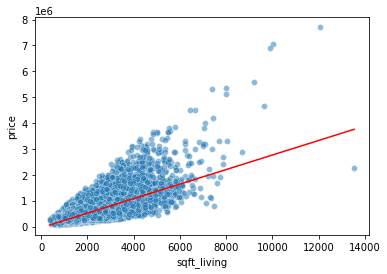

In [8]:
# Get the specific columns out we want for the regression
X = stripped_down_df.loc[:, ['sqft_living']]
y = stripped_down_df.loc[:, ['price']]
plot_data = stripped_down_df.loc[:, ['price', 'sqft_living']]


beginner_reg = LinearRegression()
beginner_reg.fit(X, y)
prediction = beginner_reg.predict(X)

# Plot regression line over scatter plot
fig, ax = plt.subplots()
sns.scatterplot(data=plot_data, x='sqft_living', y='price', ax=ax, alpha=0.5);
sns.lineplot(x=X['sqft_living'], y=prediction[:, 0], ax=ax, color='r');


In [9]:
print(f"R Squared Score: {beginner_reg.score(X, y)}")

R Squared Score: 0.49268789904035093


In [10]:
stats_models_version = sm.OLS(y['price'], sm.add_constant(X)).fit()
stats_models_version.summary()

In [12]:
inter_df = stripped_down_df.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built', 'price']]
X_more = inter_df.drop('price', axis=1)
y_more = inter_df.price

inter_reg = LinearRegression()
inter_reg.fit(X_more, y_more)
print(f"R Squared Score: {inter_reg.score(X_more, y_more)}")
print(f"Coefficients: {inter_reg.coef_}")


R Squared Score: 0.5562851846502235
Coefficients: [ 3.03767349e+02  6.74690231e+04 -6.89999611e+04 -3.01545416e-01
  5.42136300e+04 -3.36761796e+03]


In [14]:
stats_models_version_inter = sm.OLS(y_more, sm.add_constant(X_more)).fit()
stats_models_version_inter.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                     4511.
Date:                Fri, 07 Jan 2022   Prob (F-statistic):               0.00
Time:                        08:41:09   Log-Likelihood:            -2.9862e+05
No. Observations:               21597   AIC:                         5.972e+05
Df Residuals:                   21590   BIC:                         5.973e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        6.559e+06   1.35e+05     48.643      0.000     6.3e+06    6.82e+06
sqft_living   303.7673      3.000    101.249      0.000     297.887     309.648
bathrooms    6.747e+04   3851.524     17.517      0.000    5.99e+04     7.5e+04
bedrooms      -6.9e+04   2253.108    -30.624      0.000   -7.34e+04   -6.46e+04
sqft_lot       -0.3015      0.041     -7.329      0.000      -0.382      -0.221
floors       5.421e+04   3778.051     14.350      0.000    4.68e+04    6.16e+04
yr_built    -3367.6180     70.002    -48.107      0.000   -3504.828   -3230.408
==============================================================================
Omnibus:                    14312.566   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           522258.106
Skew:                           2.680   Prob(JB):                         0.00
Kurtosis:                      26.487   Cond. No.                     3.57e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Needs Improvement

So far both models have had signs of multicollinearity.

## Train Test Split Versions

In [19]:
# Split with random state for repeatability
X_train, X_test, y_train, y_test = train_test_split(kc_house_df.drop('price', axis=1), kc_house_df.price, test_size=0.3, random_state=1)

##### Simple Regression

In [20]:
# Get the specific column out we want for the regression
X_simple_train = X_train.loc[:, ['sqft_living']]
y_simple_train = y_train


simple_split_reg = LinearRegression()
simple_split_reg.fit(X_simple_train, y_simple_train)
print(f"R Squared Score: {simple_split_reg.score(X_simple_train, y_simple_train)}")
print(f"Coefficients: {simple_split_reg.coef_}")

R Squared Score: 0.4875906720013805
Coefficients: [284.19711911]


##### Multiple Regression: numerical data

In [21]:
X_more_train = X_train.loc[:, ['sqft_living', 'bathrooms', 'bedrooms', 'sqft_lot', 'floors', 'yr_built']]

inter_train_reg = LinearRegression()
inter_train_reg.fit(X_more_train, y_train)
print(f"R Squared Score: {inter_train_reg.score(X_more_train, y_train)}")
print(f"Coefficients: {inter_train_reg.coef_}")

R Squared Score: 0.5531144672260686
Coefficients: [ 3.09252352e+02  6.78876981e+04 -7.09599994e+04 -3.03151078e-01
  5.39135851e+04 -3.43204783e+03]


##### Multiple Regression: categorical data cleaned and encoded.

In [22]:
X_stripped_down_train = X_train.loc[:, ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]
X_stripped_down_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 8093 to 235
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           15117 non-null  int64  
 1   bedrooms     15117 non-null  int64  
 2   bathrooms    15117 non-null  float64
 3   sqft_living  15117 non-null  int64  
 4   sqft_lot     15117 non-null  int64  
 5   floors       15117 non-null  float64
 6   waterfront   13442 non-null  object 
 7   condition    15117 non-null  object 
 8   grade        15117 non-null  object 
 9   yr_built     15117 non-null  int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 1.3+ MB


In [23]:
# fill nulls
water_imputer = SimpleImputer(strategy='most_frequent')
X_stripped_down_train['waterfront'] = water_imputer.fit_transform(X_stripped_down_train['waterfront'].values.reshape(-1,1))[:, 0]

##### Ordinal Encode

In [24]:
water_front_vals = X_stripped_down_train[['waterfront']]
# separate encoder to be used to convert test data to usable form later
water_encoder = OrdinalEncoder()
# only fit on training data
water_encoder.fit(water_front_vals)
# transform and flatten training data
water_train_transform = water_encoder.transform(water_front_vals).flatten()
# replace original categorical with new boolean, integer data
X_stripped_down_train['waterfront'] = water_train_transform

##### One Hot Encode

Grade column:

In [25]:
grade_train_vals = X_stripped_down_train[['grade']]
# grade encoder for later use, drops first column to avoid multicollinearity
grade_ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
grade_ohe.fit(grade_train_vals)
grade_train_encoded = grade_ohe.transform(grade_train_vals)
# get list of nicer column names
grade_categories = [f"Grade: {cat.split()[0]}" for cat in grade_ohe.categories_[0][1:]]
# convert to dataframe for ease of use
grade_train_encoded = pd.DataFrame(grade_train_encoded, columns=grade_categories, index=X_stripped_down_train.index)
# drop old column
X_stripped_down_train = X_stripped_down_train.drop("grade", axis=1)
# add in new columns
X_stripped_down_train = pd.concat([X_stripped_down_train, grade_train_encoded], axis=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,yr_built,Grade: 11,Grade: 12,Grade: 13,Grade: 3,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9
8093,123039424,2,2.00,970,9750,1.0,0.0,Very Good,1940,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13884,3550800040,3,1.00,940,7980,1.0,0.0,Average,1961,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
406,7821200390,3,2.00,1290,1213,3.0,0.0,Average,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
21317,2424059174,4,3.25,5640,35006,2.0,0.0,Average,2015,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7766,7893205080,3,1.50,1230,7500,1.0,0.0,Average,1962,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,8731901610,3,2.25,2420,7548,1.0,0.0,Good,1967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
17289,9284801100,3,1.50,1060,5750,1.0,0.0,Fair,1981,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5192,3578400950,3,1.75,1540,13002,1.0,0.0,Fair,1984,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12172,5561400140,3,2.50,2420,49928,2.0,0.0,Average,1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Condition column:

In [26]:
condition_train_vals = X_stripped_down_train[['condition']]
# exactly the same process as for the grade category
condition_ohe = OneHotEncoder(categories='auto', sparse=False, drop='first')
condition_ohe.fit(condition_train_vals)
condition_train_encoded = condition_ohe.transform(condition_train_vals)
condition_categories = [f"Condition: {cat}" for cat in condition_ohe.categories_[0][1:]]
# convert to dataframe for ease of use
condition_train_encoded = pd.DataFrame(condition_train_encoded, columns=condition_categories, index=X_stripped_down_train.index)
# drop old column
X_stripped_down_train = X_stripped_down_train.drop("condition", axis=1)
# add in new columns
X_stripped_down_train = pd.concat([X_stripped_down_train, condition_train_encoded], axis=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_built,Grade: 11,Grade: 12,...,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9,Condition: Fair,Condition: Good,Condition: Poor,Condition: Very Good
8093,123039424,2,2.00,970,9750,1.0,0.0,1940,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
13884,3550800040,3,1.00,940,7980,1.0,0.0,1961,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406,7821200390,3,2.00,1290,1213,3.0,0.0,2001,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21317,2424059174,4,3.25,5640,35006,2.0,0.0,2015,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7766,7893205080,3,1.50,1230,7500,1.0,0.0,1962,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,8731901610,3,2.25,2420,7548,1.0,0.0,1967,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
17289,9284801100,3,1.50,1060,5750,1.0,0.0,1981,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
5192,3578400950,3,1.75,1540,13002,1.0,0.0,1984,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
12172,5561400140,3,2.50,2420,49928,2.0,0.0,1985,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [27]:
X_stripped_down_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15117 entries, 8093 to 235
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    15117 non-null  int64  
 1   bedrooms              15117 non-null  int64  
 2   bathrooms             15117 non-null  float64
 3   sqft_living           15117 non-null  int64  
 4   sqft_lot              15117 non-null  int64  
 5   floors                15117 non-null  float64
 6   waterfront            15117 non-null  float64
 7   yr_built              15117 non-null  int64  
 8   Grade: 11             15117 non-null  float64
 9   Grade: 12             15117 non-null  float64
 10  Grade: 13             15117 non-null  float64
 11  Grade: 3              15117 non-null  float64
 12  Grade: 4              15117 non-null  float64
 13  Grade: 5              15117 non-null  float64
 14  Grade: 6              15117 non-null  float64
 15  Grade: 7          

In [28]:
cat_train_reg = LinearRegression()
cat_train_reg.fit(X_stripped_down_train, y_train)
print(f"R Squared Score: {cat_train_reg.score(X_stripped_down_train, y_train)}")
print(f"Coefficients: {cat_train_reg.coef_}")

R Squared Score: 0.6716469637540805
Coefficients: [-9.34831828e-07 -2.94287708e+04  5.57039035e+04  1.48185789e+02
 -2.30046150e-01  3.02907767e+04  7.58280753e+05 -3.52011485e+03
  2.61637058e+05  8.07828788e+05  2.04405252e+06 -5.73086514e+05
 -5.33374201e+05 -5.53982855e+05 -4.96624024e+05 -4.14948269e+05
 -3.21198495e+05 -1.72753920e+05 -3.14388214e+04  2.09110239e+04
 -4.28218048e+04  5.22301449e+04]


#### Winner: Multiple regression with categorical data

The last regression had the highest R squared score out of all, time to test it. WE need to apply the same cleaning and feature cleanup to the test data first.

In [29]:
# Begin transforming test data in the same way
X_stripped_down_test = X_test.loc[:, ['id', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'condition', 'grade', 'yr_built']]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6480 entries, 16729 to 20705
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6480 non-null   int64  
 1   bedrooms     6480 non-null   int64  
 2   bathrooms    6480 non-null   float64
 3   sqft_living  6480 non-null   int64  
 4   sqft_lot     6480 non-null   int64  
 5   floors       6480 non-null   float64
 6   waterfront   5779 non-null   object 
 7   condition    6480 non-null   object 
 8   grade        6480 non-null   object 
 9   yr_built     6480 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 556.9+ KB


In [30]:
# fill nulls
X_stripped_down_test['waterfront'] = water_imputer.transform(X_stripped_down_test['waterfront'].values.reshape(-1,1))[:, 0]

##### Ordinal Encode

In [31]:
water_front_test_vals = X_stripped_down_test[['waterfront']]
water_test_transform = water_encoder.transform(water_front_test_vals).flatten()
# replace original categorical with new boolean, integer data
X_stripped_down_test['waterfront'] = water_test_transform

##### One Hot Encode

In [32]:
# Grade column

grade_test_vals = X_stripped_down_test[['grade']]
# grade encoder for later use, drops first column to avoid multicollinearity
grade_test_encoded = grade_ohe.transform(grade_test_vals)
# convert to dataframe for ease of use
grade_test_encoded = pd.DataFrame(grade_test_encoded, columns=grade_categories, index=X_stripped_down_test.index)
# drop old column
X_stripped_down_test = X_stripped_down_test.drop("grade", axis=1)
# add in new columns
X_stripped_down_test = pd.concat([X_stripped_down_test, grade_test_encoded], axis=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,condition,yr_built,Grade: 11,Grade: 12,Grade: 13,Grade: 3,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9
16729,8562000010,3,1.75,1210,8864,1.0,0.0,Average,1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10996,4363700200,4,1.00,1190,7920,1.0,0.0,Average,1951,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12089,8165501620,2,2.25,1550,1824,2.0,0.0,Average,2007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
554,8718500075,3,1.50,1300,8280,1.0,0.0,Very Good,1956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16075,6154900005,4,2.75,2420,7102,1.0,0.0,Very Good,1946,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,6137610620,4,2.50,2590,9354,2.0,0.0,Good,1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4326,3343901340,3,1.75,1460,9261,1.0,0.0,Average,1985,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7353,4217400420,3,1.50,1340,6000,1.5,0.0,Average,1927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6774,3303950080,3,2.50,1950,7421,2.0,0.0,Average,1996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [33]:
# Condition column

condition_test_vals = X_stripped_down_test[['condition']]
# exactly the same process as for the grade category
condition_test_encoded = condition_ohe.transform(condition_test_vals)
# convert to dataframe for ease of use
condition_test_encoded = pd.DataFrame(condition_test_encoded, columns=condition_categories, index=X_stripped_down_test.index)
# drop old column
X_stripped_down_test = X_stripped_down_test.drop("condition", axis=1)
# add in new columns
X_stripped_down_test = pd.concat([X_stripped_down_test, condition_test_encoded], axis=1)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,yr_built,Grade: 11,Grade: 12,...,Grade: 4,Grade: 5,Grade: 6,Grade: 7,Grade: 8,Grade: 9,Condition: Fair,Condition: Good,Condition: Poor,Condition: Very Good
16729,8562000010,3,1.75,1210,8864,1.0,0.0,1985,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10996,4363700200,4,1.00,1190,7920,1.0,0.0,1951,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12089,8165501620,2,2.25,1550,1824,2.0,0.0,2007,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
554,8718500075,3,1.50,1300,8280,1.0,0.0,1956,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
16075,6154900005,4,2.75,2420,7102,1.0,0.0,1946,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17975,6137610620,4,2.50,2590,9354,2.0,0.0,1993,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4326,3343901340,3,1.75,1460,9261,1.0,0.0,1985,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7353,4217400420,3,1.50,1340,6000,1.5,0.0,1927,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6774,3303950080,3,2.50,1950,7421,2.0,0.0,1996,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [34]:
X_stripped_down_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6480 entries, 16729 to 20705
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    6480 non-null   int64  
 1   bedrooms              6480 non-null   int64  
 2   bathrooms             6480 non-null   float64
 3   sqft_living           6480 non-null   int64  
 4   sqft_lot              6480 non-null   int64  
 5   floors                6480 non-null   float64
 6   waterfront            6480 non-null   float64
 7   yr_built              6480 non-null   int64  
 8   Grade: 11             6480 non-null   float64
 9   Grade: 12             6480 non-null   float64
 10  Grade: 13             6480 non-null   float64
 11  Grade: 3              6480 non-null   float64
 12  Grade: 4              6480 non-null   float64
 13  Grade: 5              6480 non-null   float64
 14  Grade: 6              6480 non-null   float64
 15  Grade: 7        

In [35]:
# Score on our already trained model
print(f"R Squared, test: {cat_train_reg.score(X_stripped_down_test, y_test)}")
print(f"RSME, test: {mean_squared_error(y_test, cat_train_reg.predict(X_stripped_down_test), squared=False)}")

0.6744670127016534

#### Inferential checking

We've had a basic sense of the predictive potential of this setup. Now we'll take a look at what we can learn from an inferential perspective.

In [45]:
def check_inference_usefulness(model, X_train, X_test, y_test):
    """A function to check the potential usefullness of a model to an inferential perspective.
    Requires scipy.stats as stats and statsmodel as sm. Code taken from Linear Regression cumulative lab:
    https://github.com/learn-co-curriculum/dsc-linear-regression-lab"""
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    fig, axes = plt.subplots(ncols=2, figsize=(10,4))

    # Create prediction list and residuals
    preds = model.predict(X_test)
    residuals = (y_test - preds)

    # Plot for linearity assumption
    perfect_line = np.arange(y_test.min(), y_test.max())
    axes[0].plot(perfect_line, linestyle="--", color="orange", label="Perfect Fit")
    axes[0].scatter(y_test, preds, alpha=0.5)
    axes[0].set_xlabel("Actual Dependent Variable")
    axes[0].set_ylabel("Predicted Dependent Variable")
    axes[0].legend()

    # Plot for normality checking
    sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)

    # Plot to check homoscedasticity
    axes[1].scatter(preds, residuals, alpha=0.5)
    axes[1].plot(preds, [0 for i in range(len(X_test))])
    axes[1].set_xlabel("Predicted Value")
    axes[1].set_ylabel("Actual - Predicted Value");

    # Multicollinearity checking, anything over 5 is considered too high.
    vif = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    vif = [f'!!!{val} > 5, Too High!!!' if val > 5 else val for val in vif]
    return pd.Series(vif, index=X_train.columns, name="Variance Inflation Factor")

    

id                                                    3.61037
bedrooms                                              1.68189
bathrooms                                             3.02241
sqft_living                                           4.40181
sqft_lot                                              1.06722
floors                                                1.58821
waterfront                                            1.02415
yr_built                !!!77.76415539553241 > 5, Too High!!!
Grade: 11                                             1.37698
Grade: 12                                             1.11915
Grade: 13                                             1.06088
Grade: 3                                              1.00404
Grade: 4                                              1.06024
Grade: 5                                              1.45644
Grade: 6                                              4.10422
Grade: 7                !!!7.990712875246938 > 5, Too High!!!
Grade: 8

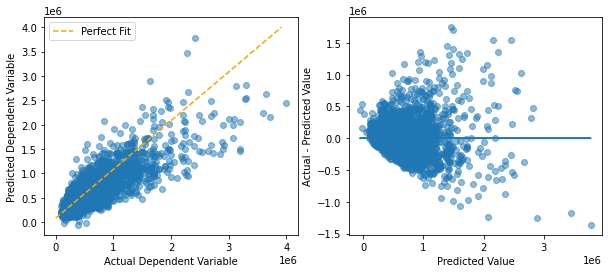

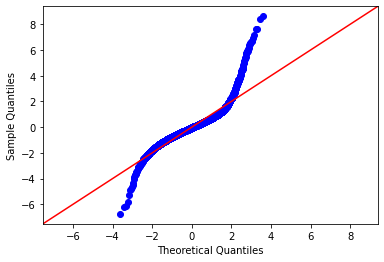

In [46]:
check_inference_usefulness(cat_train_reg, X_stripped_down_train, X_stripped_down_test, y_test)

This model does moderately well for low price values, but has issues with the higher priced data. It's overall not a terrible predictive model, but the high multicollinearity and presence of outliers in the data makes it difficult to use for inferential purposes.